# Deep Convolutional GAN Trained on NASA's Space Images

## Pt.1 Scrape Images from Flickr with bs4

#### Save the Page  
auto scroll to the bottom and save the source page as .html file.

In [ ]:
import os
from selenium import webdriver
#from selenium.webdriver.common.keys import Keys
import time

import shutil

#%%
def save_web(input_url,save_dir,scroll_num=5):
    chromrdriver = "chromedriver"
    os.environ["webdriver.chrome.driver"] = chromrdriver
    driver = webdriver.Chrome(chromrdriver)
    driver.get(input_url)
    
    for i in range(scroll_num):
        driver.execute_script("window.scrollTo(1,50000)")
        time.sleep(5)
    
    file = open(save_dir, 'w')
    file.write(driver.page_source)
    file.close()
    
    driver.close()


#### Find the Image Url  
Look for the image element with class name `awake`, the url to the image is in the `style` attribute

In [ ]:
from bs4 import BeautifulSoup
import requests

def scrape_page(page_dir,save_dir,file_name_prefix):
    page = open(page_dir,'r')
    soup = BeautifulSoup(page, 'html.parser')
    
    all_img = soup.findAll('div',class_="awake")
    
    for i, img_container in enumerate(all_img):
        img_url = 'https:'+ img_container.attrs['style'].split('"')[1]
        #img_url = 'https:'+ img_container.attrs['style'].split('url')[1][1:-1]
        img = requests.get(img_url, stream=True)
    
        if img.status_code == 200:                     #200 status code = OK
           with open(f'{save_dir}/heic_{file_name_prefix}_{i:03}.jpg', 'wb') as f: 
              img.raw.decode_content = True
              shutil.copyfileobj(img.raw, f)
        if (i%10==0):
            print(f'scraping at {file_name_prefix}_{i:03}')

In [ ]:
for i in range(2):
    index = i + 1
    file_index = index + 6
    save_web(f'https://www.flickr.com/photos/nasahubble/albums/72157695205167691/page{index}',f'saved_web/page{file_index}.html',scroll_num=6)
    scrape_page(f'saved_web/page{file_index}.html','saved_img',f'p{file_index:02}')

I went through a couple of albums in NASA's Flickr account, 1008 photos were and saved to the folder

## Pt.2 Process Dataset

In [1]:
from PIL import Image 
import PIL

import os, os.path
import matplotlib.pyplot as plt

In [ ]:
imgs = []
path = "./all_imgs"
valid_images = [".jpg",".gif",".png",".tga"]
size = 128
for i,f in enumerate(os.listdir(path)):
    ext = os.path.splitext(f)[1]
    if ext.lower() not in valid_images:
        continue
    
    img = Image.open(os.path.join(path,f))
    w,h = img.size
    
    # if the image is a square, just resize and save.
    if w==h:
        img.resize((size,size)).convert('RGB').save(f'./dataset/{i:05}.jpg')
    
    # if the image is landscape or portrait, crop the middle and then resize.
    elif w>h:
        img.crop(((w-h)/2,0,(w-h)/2+h,h)).resize((size,size)).convert('RGB').save(f'./dataset/{i:05}.jpg')
    
    elif h>w:
        img.crop((0,(h-w)/2,w,(h-w)/2+w)).resize((size,size)).convert('RGB').save(f'./dataset/{i:05}.jpg')
        
    if i%100==0:
        print(i)
    

## Pt.3 Setup the GAN and train the model  

This section is adapted from [How to Develop a GAN for Generating MNIST Handwritten Digits](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/)

In [ ]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot

from tensorflow import config

physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
	model = Sequential()
	# normal
	model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 40x40
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 20x30
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 10x10
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample to 5x5
	model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 5x5 feature maps
	n_nodes = 128 * 5 * 5
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((5, 5, 128)))
	# upsample to 10x10
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 20x20
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 40x40
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 80x80
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer 80x80x3
	model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
def process_dataset(dataset):
    X = dataset.astype('float32')
	# scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X
# load and prepare training images
def load_real_samples():
	# load the face dataset
	data = load('img_align_celeba.npz')
	X = data['arr_0']
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = process_dataset(dataset)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

## Pt.4 Generate New Images!

In [2]:
from tensorflow.keras.models import load_model

from tensorflow import config

physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [21]:
model = load_model('./730/generator_model_700.h5')

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3200)              323200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 128)       147584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 128)       147584    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 20, 20, 128)      

Generate latent points

In [5]:
from numpy import asarray
from numpy.random import randn
from numpy import linspace,concatenate

 # generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)

In [32]:
pts = generate_latent_points(100,6)
interpolated = interpolate_points(pts[0],pts[1],8)
for i in range(1,len(pts)-1):
    interpolated = concatenate([interpolated,interpolate_points(pts[i],pts[i+1],8)],axis=0)
print(interpolated.shape)

(40, 100)


In [33]:
generated = model.predict(interpolated)

In [34]:
generated_rgb = (generated + 1)*127.5
generated_rgb = generated_rgb.astype(int)

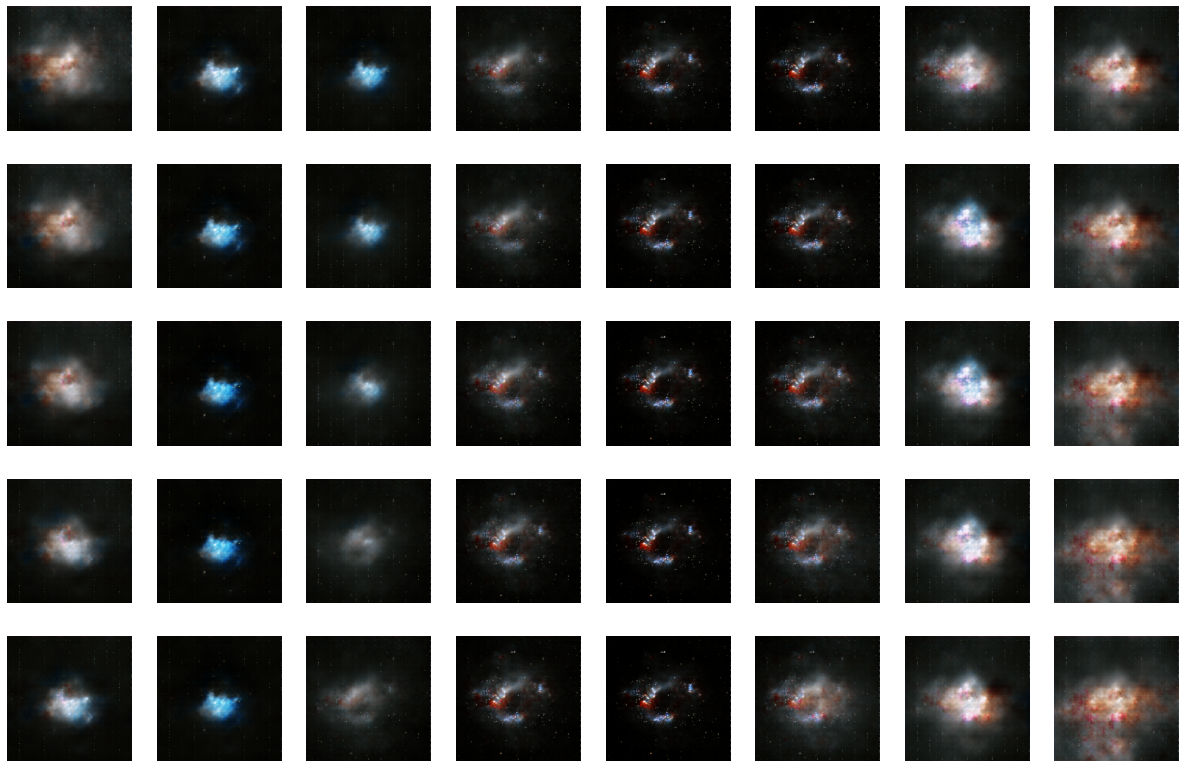

In [35]:
y=5
x=8

fig, axes = plt.subplots(y,x,figsize=(21,14))

for i in range(generated.shape[0]):
    axes[i%y,int(i/y)].axis('off')
    axes[i%y,int(i/y)].imshow(generated_rgb[i])
    

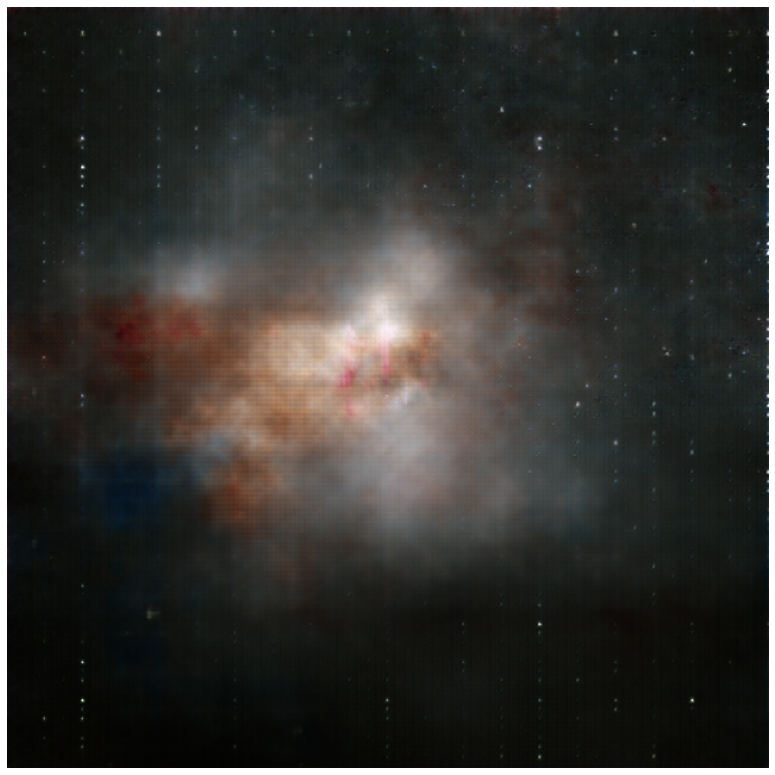

In [39]:
plt.figure(figsize=(14,14))
plt.axis('off')
plt.imshow(generated_rgb[0])

(1, 100)


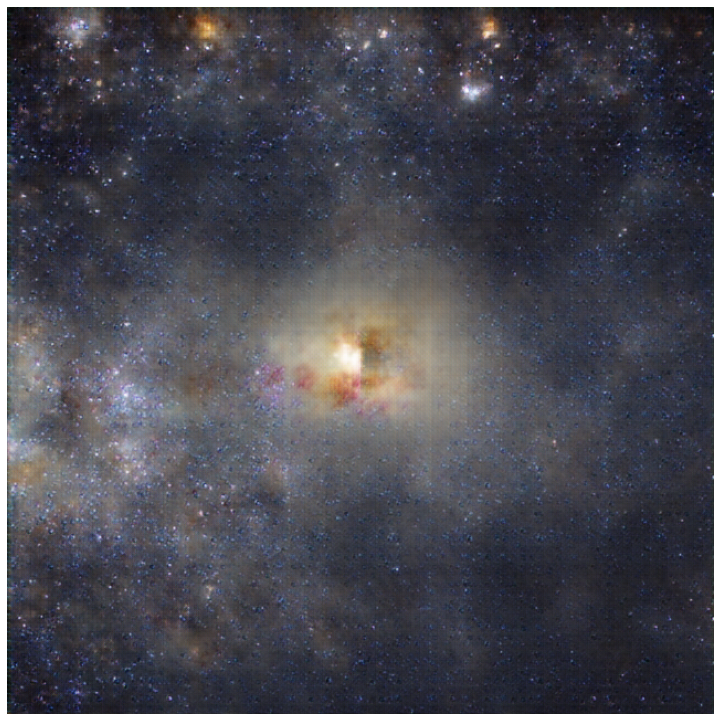

In [39]:
pt = generate_latent_points(100,1)
print(pt.shape)
generated = model.predict(pt)
generated_rgb = (generated + 1)*127.5
generated_rgb = generated_rgb.astype(int)
plt.figure(figsize=(13,13))
plt.axis('off')
plt.imshow(generated_rgb[0])

In [27]:
marked_points = pt

In [34]:
marked_points = concatenate([marked_points,pt],axis=0)
print(marked_points.shape)

(4, 100)


In [35]:
steps = 160
interpolated = interpolate_points(marked_points[0],marked_points[1],steps)
for i in range(1,len(marked_points)-1):
    interpolated = concatenate([interpolated,interpolate_points(marked_points[i],marked_points[i+1],steps)],axis=0)
print(interpolated.shape)

(480, 100)


In [36]:
generated = model.predict(interpolated)
generated_rgb = (generated + 1)*127.5
generated_rgb = generated_rgb.astype(int)
for i, img in enumerate(generated_rgb):
    plt.figure(figsize=(13,13))
    plt.axis('off')
    plt.imshow(generated_rgb[i])
    plt.savefig(f'./generated/img_03_{i:04}.png')
    plt.close()
    if i%100==0:
        print(f'saving {i}')

saving 0
saving 100
saving 200
saving 300
saving 400
